# HarvestStat Data Profiling - Ghana

In [2]:
import os, sys, glob, json
# os.chdir('../HarvestStat/notebook/')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [4]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32631' # Ghana
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/GH_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
#PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
# auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country':  'Ghana',
    'product': ['R011','R012','R013','R014','R015','R017','R018'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

In [3]:
# Save data
df_raw_out = '../data/crop_raw_data/adm_crop_data_raw_GH.csv'
df.to_csv(df_raw_out); print(f'{df_raw_out} is saved.')

../data/crop_raw_data/adm_crop_data_raw_GH.csv is saved.


In [4]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting
# a.1) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a.2) Early in the record the catch-all crop production system is 'all' rather than none. Make these to none-type
df.loc[df['crop_production_system'] == 'all', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #
#Drop the hundreds of blank (nan) rows that are duplicates of rows that do have data
df = df[np.isfinite(df.value)]
# df = df.dropna(subset=['admin_2'])

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# # FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([GH_Admin1_1982,GH_Admin1_1983,GH_Admin1_1989,GH_Admin1_2004,GH_Admin1_2008,GH_Admin1_2012,GH_Admin1_2018], axis=0)
PlotAdminShapes(shape_used, label=True)
# # ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 5,968
67/67 "Area Harvested" points are retained.
2,042/2,042 "Area Planted" points are retained.
1,940/1,940 "Quantity Produced" points are retained.
1,919/1,919 "Yield" points are retained.
Current data points: 5,968

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1984 - 2022
17 grain types are found: African oil palm nut, Bambara groundnut, Cassava, Cooking Banana (unspecified), Cowpea (unspecified), Groundnuts (In Shell), Maize (Corn), Millet, Okras (Fresh), Rice (Paddy), Sorghum, Soybean (unspecified), Sugarcane (for sugar), Sweet Potatoes, Taro/Cocoyam (Unspecified), Tomato, Yams
3 seasons are found: Annual (12-01), Main (12-01), Second (12-01)
1 crop production system are found: All (PS)
Data sources include:
[1] GSS, Ghana --- Official agricultural statistics, Ghana
[2] MOFA, Ghana --- Official agricultural statistics, Ghana
Administrative-1

## Ghana
Ghana crop seasonal calendar

<!-- ![FEWS NET](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-cameroon.png?itok=FlNQVtNG) -->

![USDA](https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/wafrica_gh_calendar.png)


- comparison of boundaries
![image](../figures/GH_admin_shapes.png)

- In Ghana, basd on the FEWS NET data, there was one time of change in administrative units: 2018

| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  | :---:  |:---:  |
| 1970	 | GH1970A1 | 8	| nan	| 0	| nan	| 0	|
| 1982	 | GH1982A1 | 9	| nan	| 0	| nan	| 0	|
| 1983	 | GH1983A1 | 10	| nan	| 0	| nan	| 0	|
| 1989	 | GH1989A1 | 10	| nan	| 0	| nan	| 0	|
| 2004	 | GH2004A1 | 10	| nan	| 0	| nan	| 0	|
| 2008	 | GH2008A1 | 10	| nan	| 0	| nan	| 0	|
| 2012	 | GH2012A1 | 10	| nan	| 0	| nan	| 0	|
| 2018	 | GH2018A1 | 16	| nan	| 0	| nan	| 0	|


- Here, we use **`GH2018A1`** to represent all admin-level 1 crop data .
- At admin-level 1,there are three seasons`Annual`,`Main`,`Second`.

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = GH_Admin1_2018.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #
# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()

In [6]:
# Link admin boundaries ------------------------- #
link_2012, over_2012= FDW_PD_CreateAdminLink(GH_Admin1_2012,GH_Admin1_2018, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2008, over_2008= FDW_PD_CreateAdminLink(GH_Admin1_2008,GH_Admin1_2018, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2004, over_2004= FDW_PD_CreateAdminLink(GH_Admin1_2004,GH_Admin1_2018, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1989, over_1989= FDW_PD_CreateAdminLink(GH_Admin1_1989,GH_Admin1_2018, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1983, over_1983= FDW_PD_CreateAdminLink(GH_Admin1_1983,GH_Admin1_2018, 'ADMIN1', 'ADMIN1', prod, epsg)

# Crop specific ratios
link_ratio_2012 = FDW_PD_RatioAdminLink(link_2012, prod, over_2012, mdx_pss)
link_ratio_2008 = FDW_PD_RatioAdminLink(link_2008, prod, over_2008, mdx_pss)
link_ratio_2004 = FDW_PD_RatioAdminLink(link_2004, prod, over_2004, mdx_pss)
link_ratio_1989 = FDW_PD_RatioAdminLink(link_1989, prod, over_1989, mdx_pss)
link_ratio_1983 = FDW_PD_RatioAdminLink(link_1983, prod, over_1983, mdx_pss)

# Merge link_ratio
assert link_ratio_2008.keys() == link_ratio_2012.keys()
assert link_ratio_2004.keys() == link_ratio_2012.keys()
assert link_ratio_1989.keys() == link_ratio_2012.keys()
assert link_ratio_1983.keys() == link_ratio_2012.keys()

link_merged = [link_ratio_1983,link_ratio_1989,link_ratio_2004,link_ratio_2008,link_ratio_2012]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

In [7]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_GH.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')


All [country, season_name] are in the external season calendar.
../data/crop/adm_crop_production_GH.csv is saved.


In [9]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = SO_Admin2_1990.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
df['season_name'] = df['season_name'].replace({'Gu off-season':'Gu-off', 'Deyr off-season':'Deyr-off'})
# ----------------------------------------------- #



## Visualization of production data

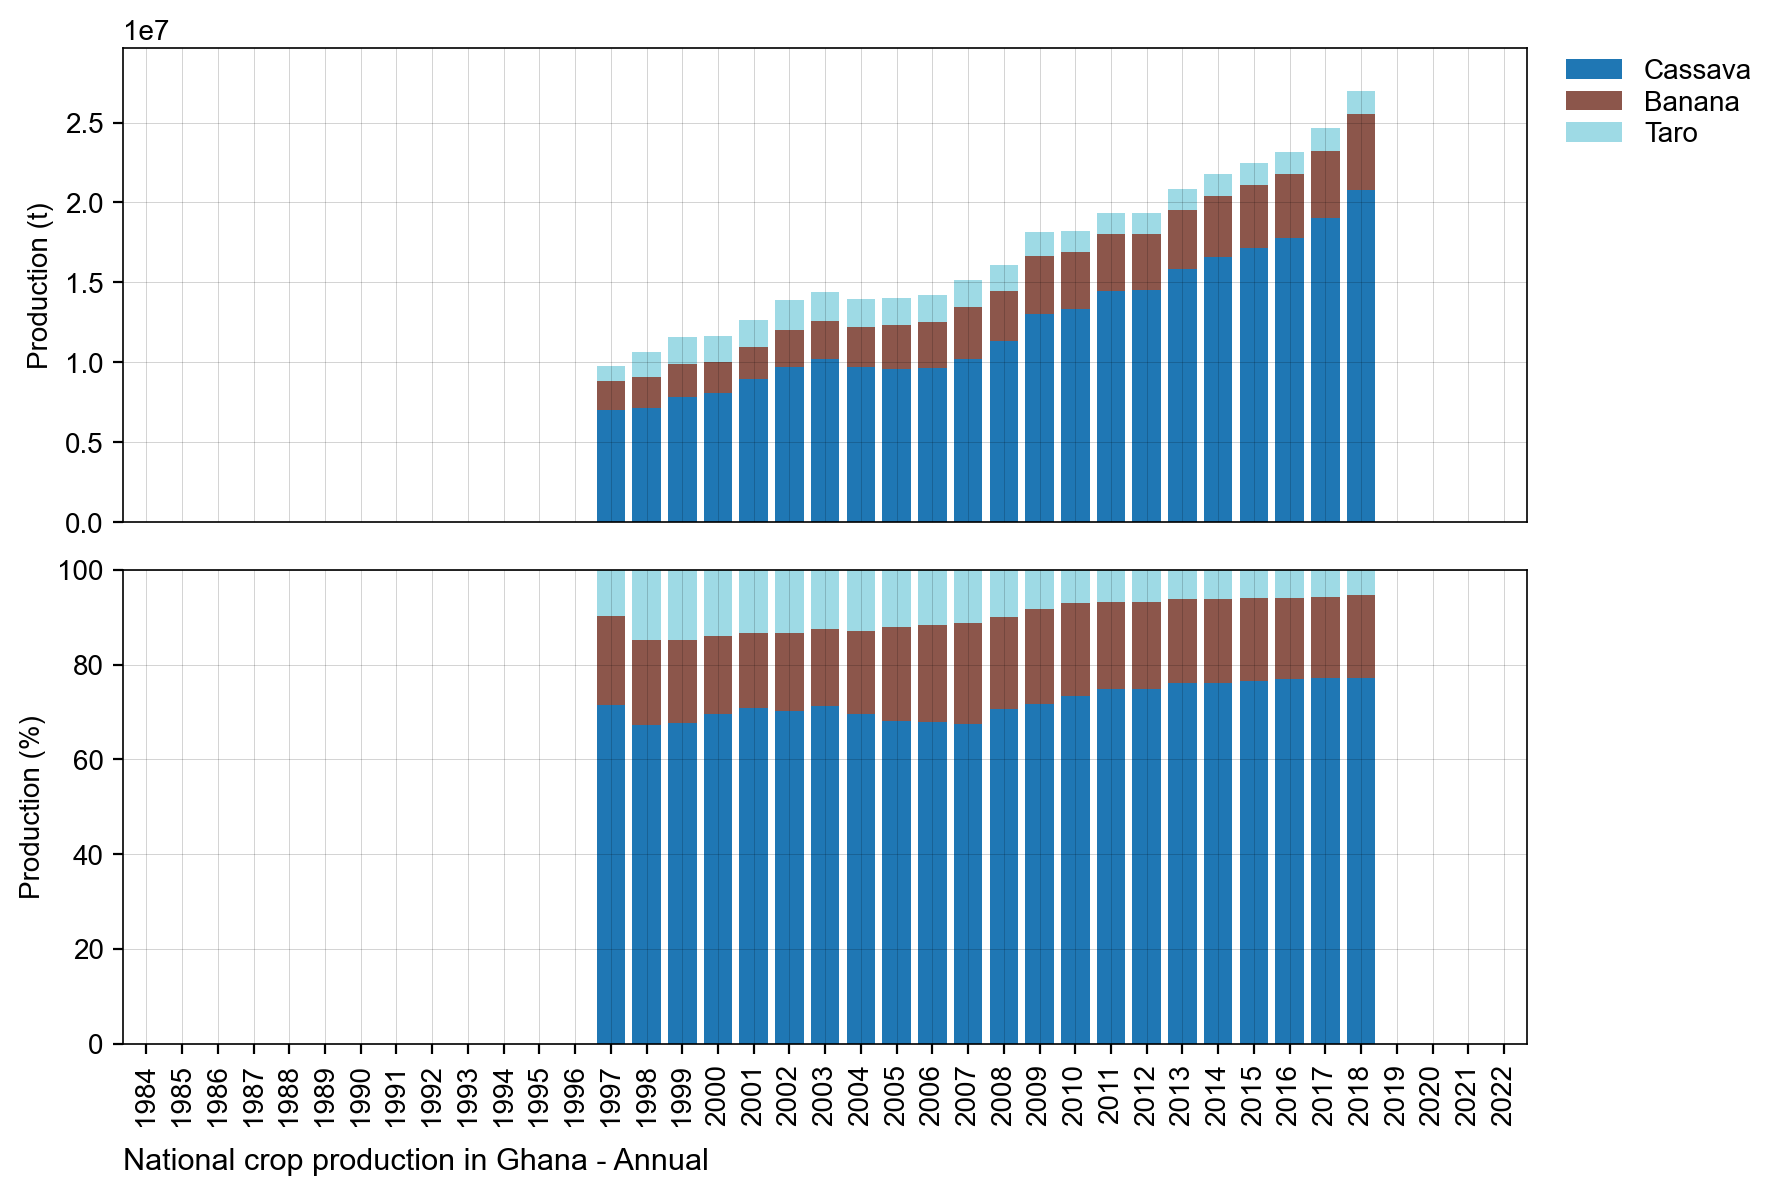

../figures/GH_bar_natgrainprod_Annual.png is saved.


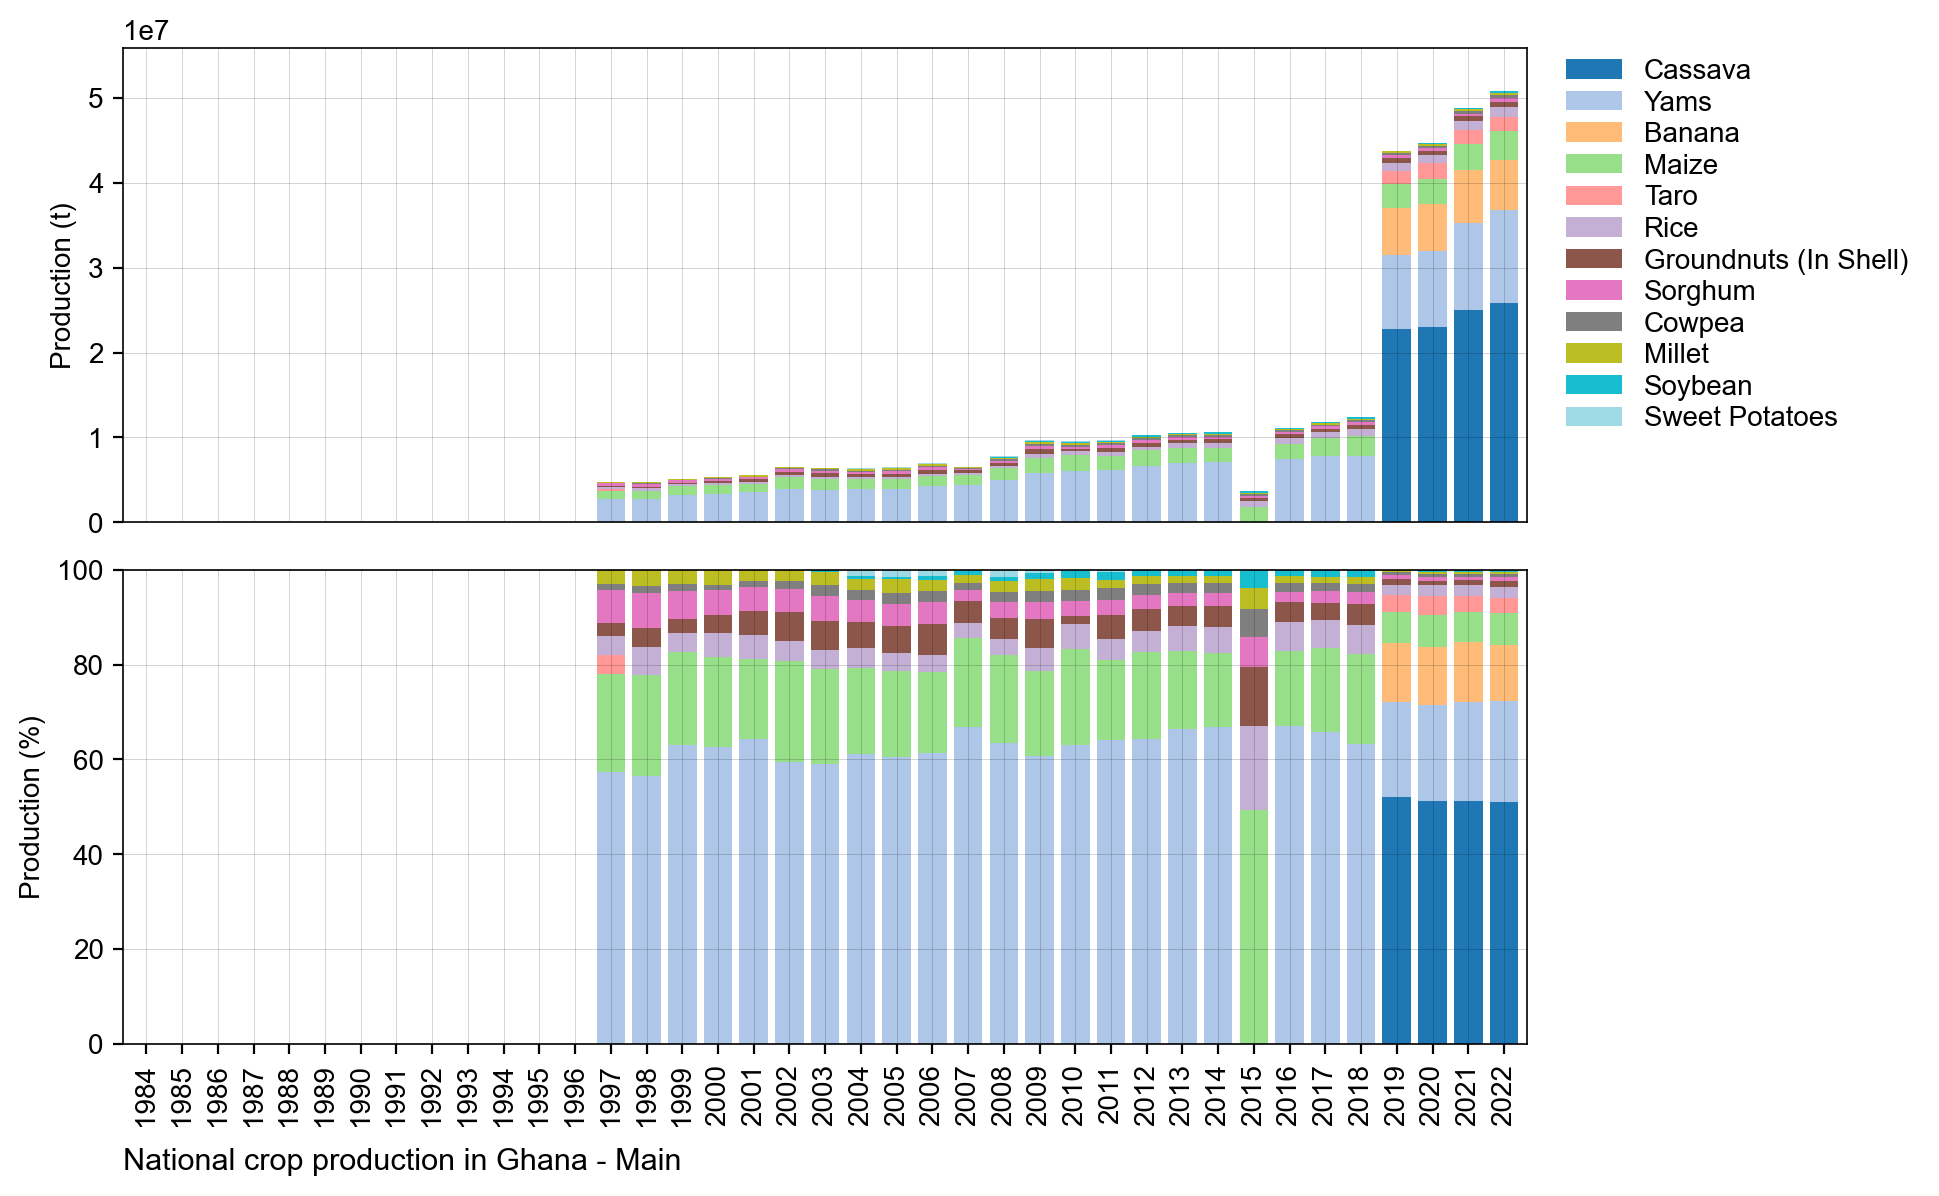

../figures/GH_bar_natgrainprod_Main.png is saved.


In [4]:
# Bar chart of national grain production
country_iso, country_name = 'GH', 'Ghana'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Maize', 'Millet', 'Sorghum', 'Rice']
for season_name in ['Annual', 'Main', 'Second']:
    footnote = 'National crop production in %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    if len(sub)<5:
        continue
    fig = PlotBarProduction(sub, year, footnote, fn_save)

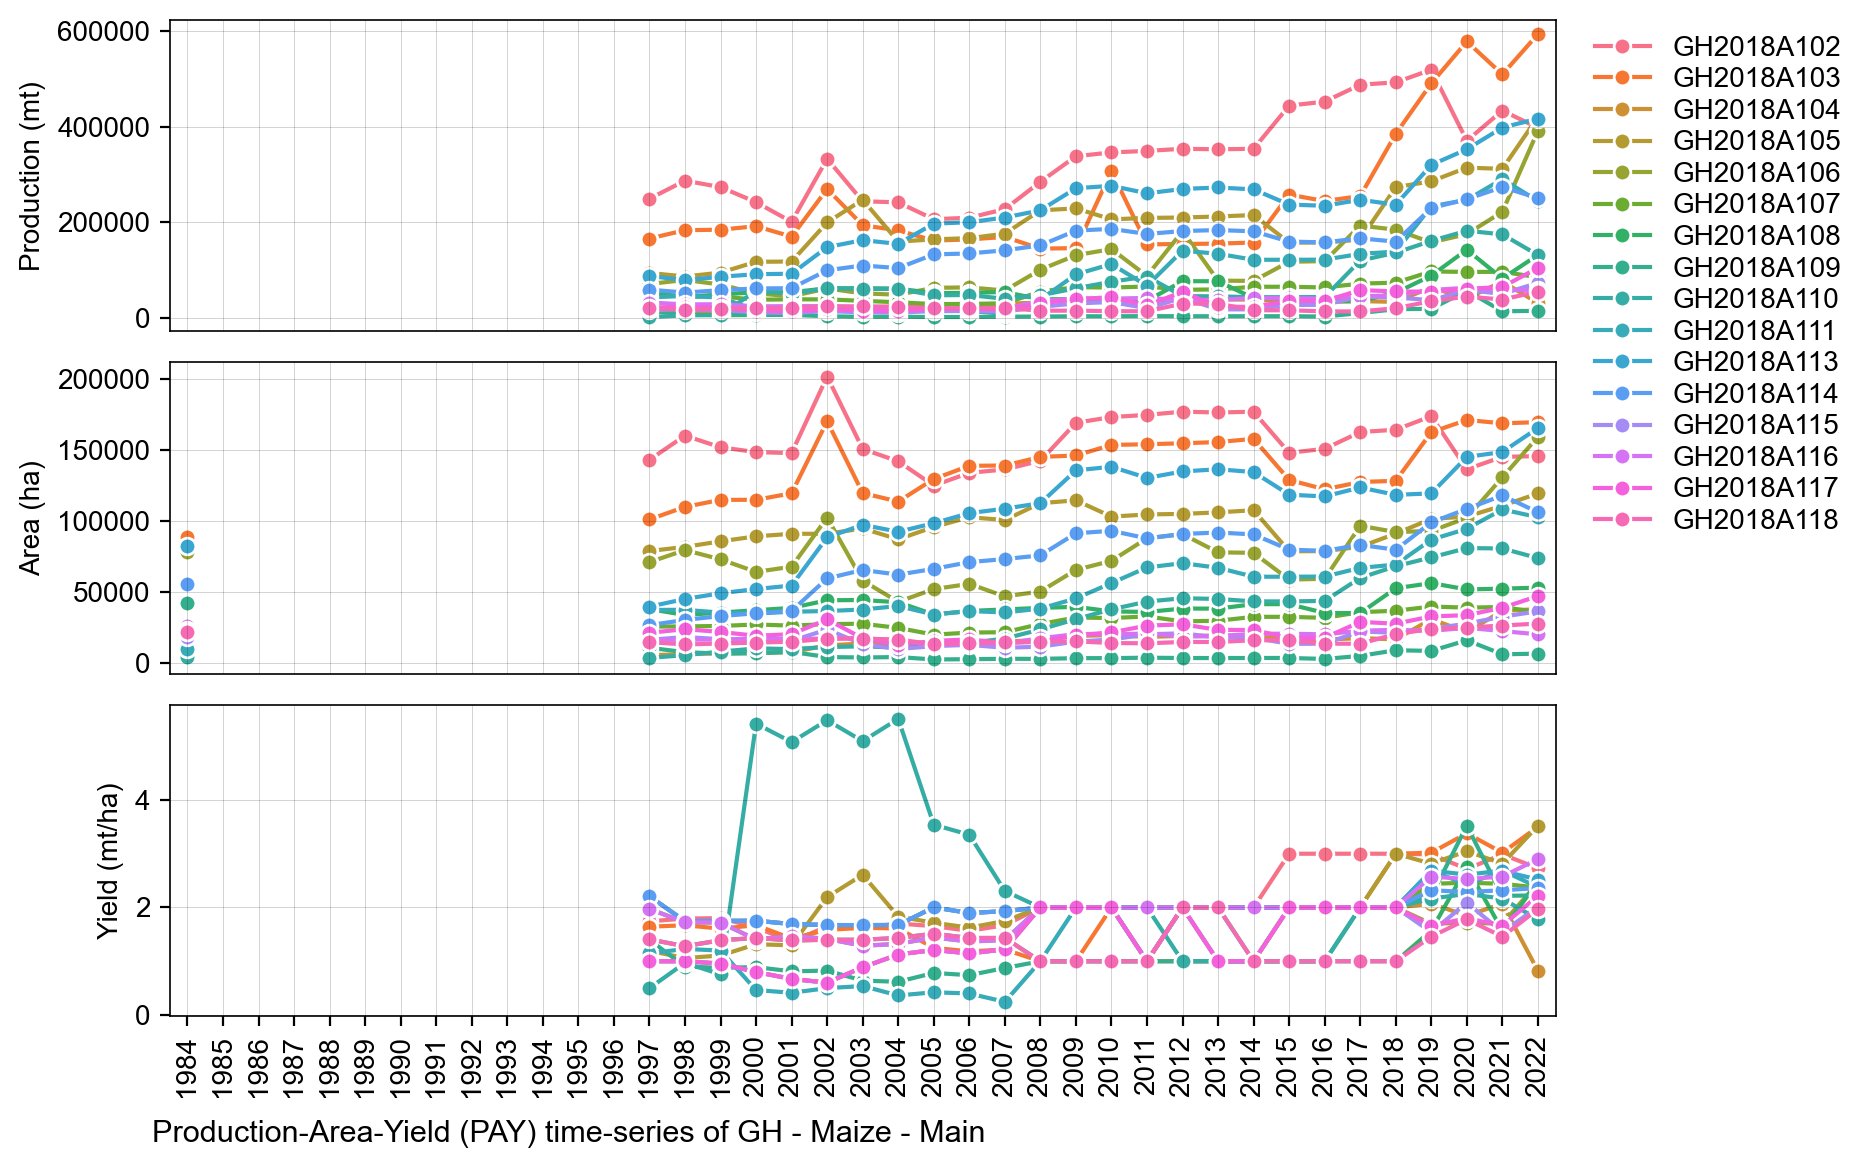

../figures/GH_line_pay_Maize_Main.png is saved.


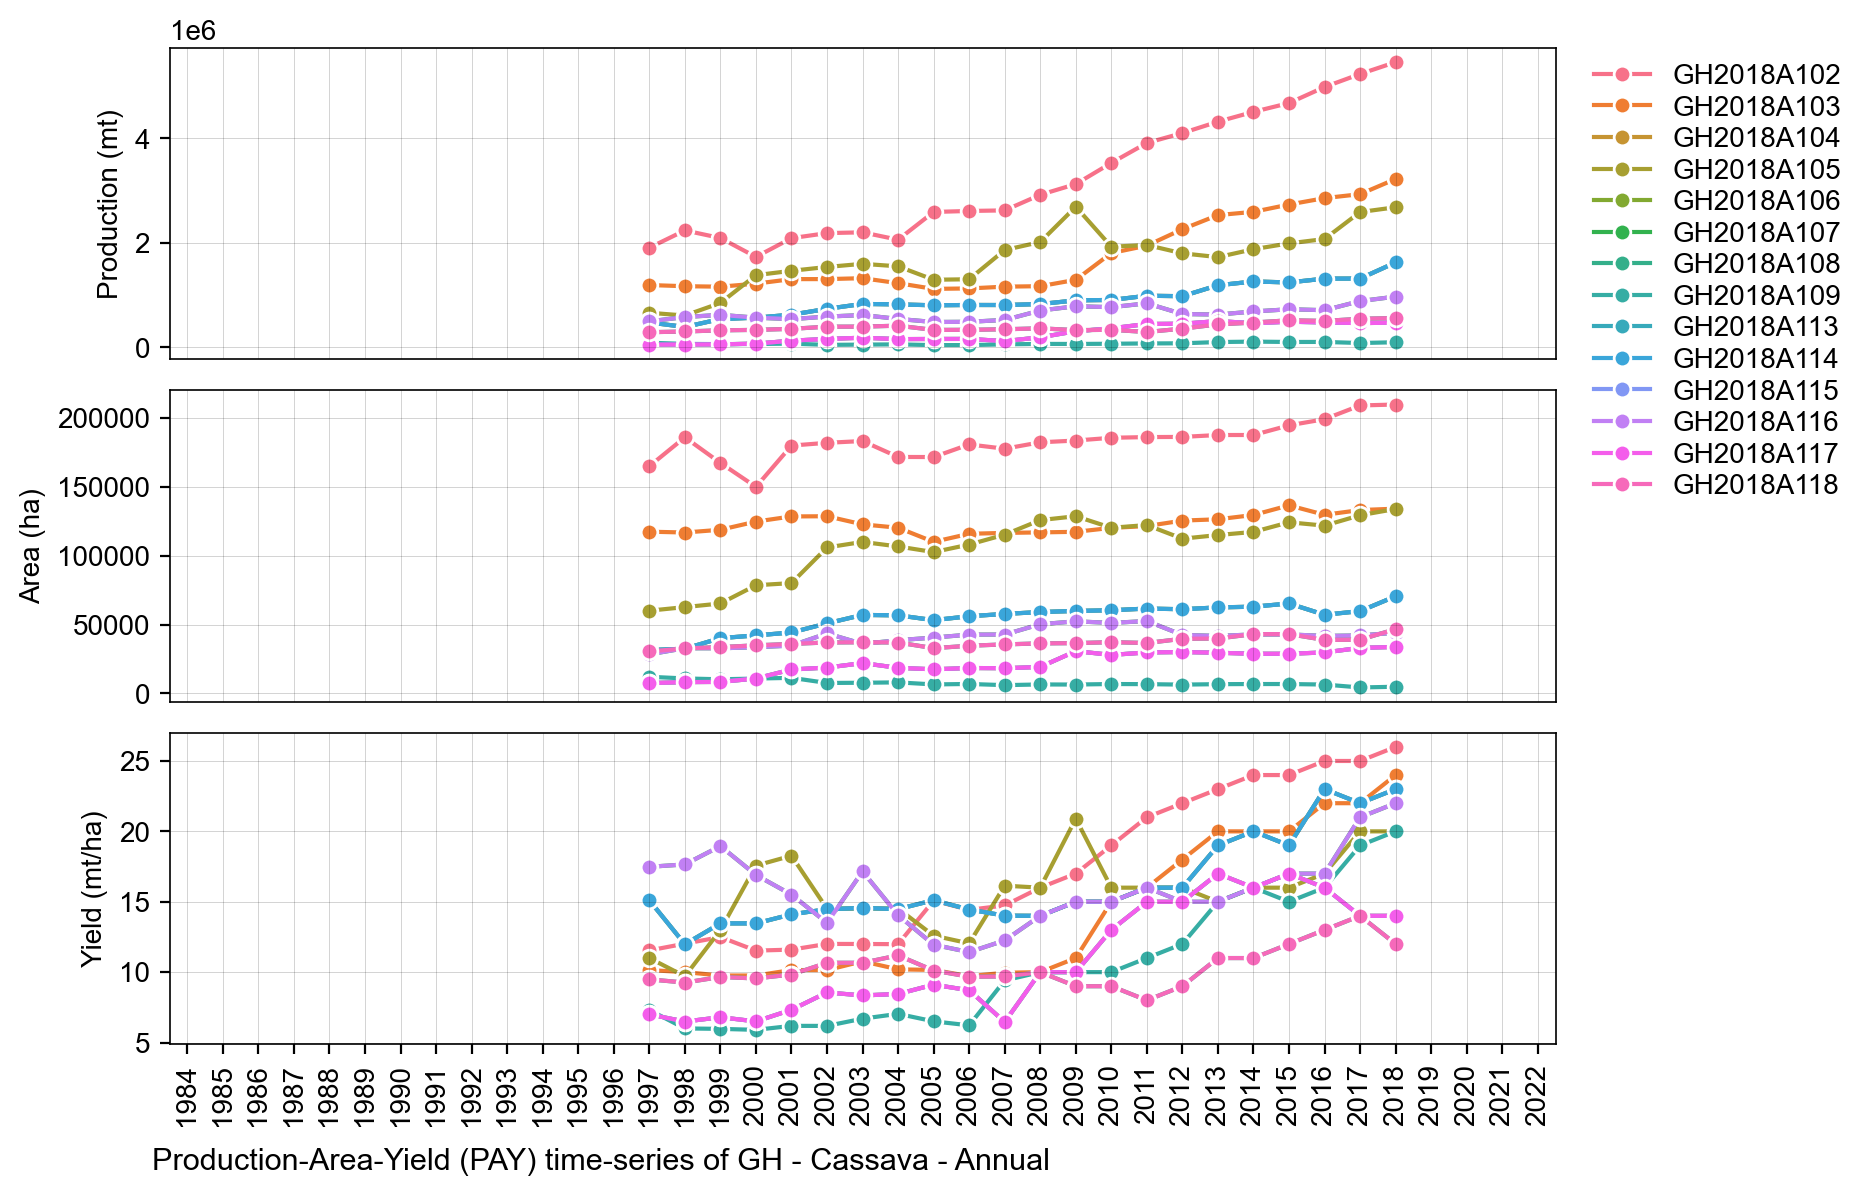

../figures/GH_line_pay_Cassava_Annual.png is saved.


In [7]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'GH', 'Ghana'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize', 'Main'],
    ['Cassava', 'Annual'],
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield (PAY) time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote, fn_save)